# Desc

- using this file to practice/learn basic stats
- also want to learn standard time series analysis techniques

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import r2_score

In [4]:

def check_stationary(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.01) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [5]:
# parameters
_round_num = 4
_time_per_day = 1000000

In [6]:
def get_file_trades(day):
    fname = f"../data/round{_round_num}/trades_round_{_round_num}_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

def get_symbol_prices(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        price_df = get_file_prices(day)
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    
    # rename "bid" to "buy"
    # rename "ask" to "sell"
    price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
    price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df

def get_all_mids(days):
    price_df = get_symbol_prices(symbol=None, days=days)
    
    symbols = set(price_df["symbol"])
    
    price_df["mid"] = (price_df["buy_price_1"] + price_df["sell_price_1"]) / 2
    
    return price_df[["time", "symbol", "mid"]].copy()

In [7]:
def get_book_large_size(price_df, side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df


def get_whale_quotes(price_df):
    # get big buy/sell quotes
    buy_df = get_book_large_size(price_df, "buy")
    sell_df = get_book_large_size(price_df, "sell")

    # create big quote_df
    quote_df = pd.merge(buy_df, sell_df, on="time")
    quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
    quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

    return quote_df

## Pairs trading

In [ ]:
_day_range = [1, 2, 3]
# _day_range = [-1, 0, 1]

coco_price_df = get_symbol_prices("COCONUTS", _day_range)
pina_price_df = get_symbol_prices("PINA_COLADAS", _day_range)

coco_df = get_whale_quotes(coco_price_df)
pina_df = get_whale_quotes(pina_price_df)
pair_df = pd.DataFrame({
    "mid_coco": coco_df["mid_price"], 
    "mid_pina": pina_df["mid_price"],
    "time": pina_df["time"],
})

fig, ax = plt.subplots()

ax.plot(pair_df["time"], pair_df["mid_coco"], color="blue", label="coco")
ax.legend(loc=1)

ax2 = ax.twinx()

ax2.plot(pair_df["time"], pair_df["mid_pina"], color="orange", label="pina")
ax2.legend(loc=2)

### plot first diffs over time

In [ ]:
plt.scatter(pair_df["mid_coco"].diff(1), pair_df["mid_pina"].diff(1))

In [ ]:
plt.figure(figsize=(12, 3))

all_x = pair_df["mid_coco"].diff(1).dropna()
all_y = pair_df["mid_pina"].diff(1).dropna()

xlim = all_x.min(), all_x.max()
ylim = all_y.min(), all_y.max()

big_model = np.poly1d(np.polyfit(all_x, all_y, deg=1))
print("big_model", big_model.coef)

### params
chunk_size = 100


model_data = []

for i in range(len(pair_df) - chunk_size):

    lb = i
    ub = lb + chunk_size

    df = pair_df.iloc[lb:ub]

    x = df["mid_coco"].diff(1).dropna()
    y = df["mid_pina"].diff(1).dropna()

    inds = x.index.intersection(y.index)

    x = x[inds]
    y = y[inds]

    # fit line
    model = np.poly1d(np.polyfit(x, y, deg=1))
    model_data += [{
        "m": model.coef[0],
        "b": model.coef[1],
        "r2": r2_score(y, model(x)),
    }]

#     if i < 5:
#         plt.subplot(121)
#         plt.hist(x, bins=50)
#         plt.hist(y, bins=50, alpha=0.5)

#         plt.subplot(122)
#         plt.scatter(x, y, s=1)
#         plt.plot(x, model(x), color="red", label="fit")
#         plt.plot(x, model(x), color="black", label="fit")
#         plt.xlim(xlim)
#         plt.ylim(ylim)
        
#         plt.show()

#         print("model", model.coef)
model_df = pd.DataFrame(model_data)

In [ ]:
plt.plot(model_df["r2"], label="r2")
plt.plot(model_df["m"], label="m")
plt.plot(model_df["b"], label="b")
plt.axhline(y=1.5)

plt.legend()


In [ ]:
check_stationary(model_df["m"])

In [ ]:
# get errors
error = pair_df["mid_pina"] - pair_df["mid_coco"] * 1.5 - 3000
error_df = pd.DataFrame({"error": error})

# check stationarity of the error
check_stationary(error_df["error"])

# get `change` stats
error_df["above"] = error_df["error"] > 0
error_df["change"] = error_df["above"] != error_df["above"].shift(1)


In [ ]:
plt.plot(error_df["error"])

In [ ]:
error.describe()

In [ ]:
low, high = 0, 0

bounds = []

for index, row in error_df.iterrows():
    if row["change"]:
        bounds += [(low, high)]
        low, high = 0, 0
        
    # record max error
    low = min(low, row["error"])
    high = max(low, row["error"])
    
    
df = pd.DataFrame(bounds, columns=["low", "high"])
df["bound"] = np.maximum(df["low"].abs(), df["high"].abs())

# get number of times we reach each threshold
freq_df = df.groupby("bound")[["low"]].count().rename({"low": "count"}, axis=1)
freq_df = freq_df.sort_index(ascending=False).cumsum().reset_index()
freq_df["pnl"] = freq_df["bound"] * freq_df["count"]

In [ ]:
plt.plot(freq_df["bound"], freq_df["pnl"])

In [ ]:
freq_df.sort_values(by="pnl", ascending=False).iloc[:20]

## round 4

In [ ]:
del pair_df

In [8]:
_day_range = [1, 2, 3]

raw_df = get_symbol_prices(None, _day_range)

syms = ["DIP", "BAGUETTE", "UKULELE", "PICNIC_BASKET"]

all_dfs = {}
for sym in syms:
    df = raw_df[raw_df["symbol"] == sym]
    df = get_whale_quotes(df)
    all_dfs[sym[:3].lower()] = df["mid_price"]
#     all_dfs["time"] = df["time"]
    

price_df = pd.DataFrame(all_dfs)

fname ../data/round4/prices_round_4_day_1.csv
fname ../data/round4/prices_round_4_day_2.csv
fname ../data/round4/prices_round_4_day_3.csv


In [9]:
price_df["agg"] = 2 * price_df["bag"] + 4 * price_df["dip"] + 1 * price_df["uku"]
price_df["orig_error"] = price_df["pic"] - price_df["agg"]

In [10]:
check_stationary(price_df["orig_error"])
display(price_df["orig_error"].describe().to_frame().T)

ADF Statistic: -5.650733
p-value: 0.000001
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


,count,mean,std,min,25%,50%,75%,max
orig_error,30000.0,375.718533,124.312974,-21.0,294.0,379.0,458.0,779.0


In [11]:
price_df["agg"]

0        73000.0
1        73013.0
2        73021.0
3        73020.0
4        73015.0
          ...   
29995    73429.0
29996    73426.0
29997    73421.0
29998    73404.0
29999    73407.0
Name: agg, Length: 30000, dtype: float64

In [ ]:
ax.twinx().plot(price_df["agg"])

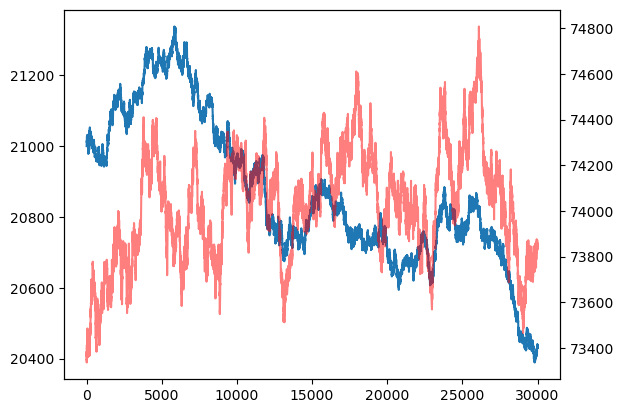

In [17]:
ax = plt.gca()
ax.plot(price_df["uku"])
ax.twinx().plot(price_df["pic"], color="red", alpha=0.5)
# ax.twinx().plot(price_df["agg"], color="green")
# ax.twinx().plot(price_df["orig_error"], color="orange")
plt.show()

In [ ]:
plt.plot(price_df["orig_error"])
plt.show()
plt.hist(price_df["orig_error"])
plt.show()

In [ ]:
def get_model(weights):
    return lambda x : np.dot(weights, list(x) + [1])

model = get_model([1, -4, -2, -1, -375])



In [ ]:
price_df["bias"] = 1
price_df["error"] = price_df[["pic", "dip", "bag", "uku"]].apply(model, axis=1)


In [ ]:
error_df = price_df[["error"]].copy()

# check stationarity of the error
check_stationary(error_df["error"])

# get `change` stats
error_df["above"] = error_df["error"] > 0
error_df["change"] = error_df["above"] != error_df["above"].shift(1)

In [ ]:
## add fees here

spreads = {
    "pic": 11.377,
    "uku": 1.419,
    "dip": 1.674,
    "bag": 1.596,
}

spread_fee = np.sum(list(spreads.values())) / 2
print("spread fee", spread_fee)

##

low, high = 0, 0

bounds = []

for index, row in error_df.iterrows():
    if row["change"]:
        bounds += [(low, high)]
        low, high = 0, 0
        
    # record max error
    low = min(low, row["error"])
    high = max(low, row["error"])
    
    
df = pd.DataFrame(bounds, columns=["low", "high"])
df["bound"] = np.maximum(df["low"].abs(), df["high"].abs())

# get number of times we reach each threshold
freq_df = df.groupby("bound")[["low"]].count().rename({"low": "count"}, axis=1)
freq_df = freq_df.sort_index(ascending=False).cumsum().reset_index()

### adjust profit by spread, you have to pay it twice
freq_df["pnl"] = (freq_df["bound"] - 2 * spread_fee) * freq_df["count"]

In [ ]:
plt.plot(freq_df["bound"], freq_df["pnl"])

In [ ]:
freq_df.sort_values(by="pnl", ascending=False).iloc[:20]